<h2>Importing Libraries</h2>

In [30]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, DenseNet121, MobileNetV3Small
from sklearn.metrics import confusion_matrix, average_precision_score
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup as bs
import shutil
import random
import glob
import warnings
import os
import time
import requests
warnings.simplefilter(action='ignore', category=FutureWarning)

<h2>Checking For GPU Availability</h2>

In [ ]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print('Num GPUs Available: ', len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

<h2>Data Preparation and Loading</h2>

In [32]:
# Search images in gettyimages with Selenium
class_names = ["tundra-wolf","domestic-dog","italian-wolf","arctic-wolf","red-wolf"]
site = ["https://www.gettyimages.com/search/2/image-film?family=creative&phrase=tundra%20wolf",
      "https://www.gettyimages.com/search/2/image?phrase=domestic%20dog&sort=mostpopular&license=rf%2Crm",
      "https://www.gettyimages.com/search/2/image?phrase=italian%20wolf&sort=mostpopular&license=rf%2Crm",
      "https://www.gettyimages.com/search/2/image?phrase=arctic%20wolf&sort=mostpopular&license=rf%2Crm",
      "https://www.gettyimages.com/search/2/image?phrase=red%20wolf"]

os.chdir("C:/Users/Admin/Python/Mini/Wolf-Subspecies/datasets")# Move directory to download file there 

cService = webdriver.ChromeService(executable_path='C:/Users/Admin/Downloads/chromedriver/chromedriver.exe')# Chromedriver path

# Creating a webdriver instance
driver = webdriver.Chrome(service = cService)

# Maximize the screen
driver.maximize_window()

for i in range(0,5):
    # Open url in the browser
    driver.get(site[i])
    # for image naming index
    index = 0

    # Going through 10 pages, as each page contains 60 images
    for p in range(0,10):
        # Class name and src of each image
        img_tag = driver.find_elements(By.CLASS_NAME,'Xc8V0Fvh0qg0lUySLpoi')
        img_url = [img.get_attribute('src') for img in img_tag if 'media.gettyimages' in img.get_attribute('src')]

        # download images
        for a, urls in enumerate(img_url[:60]):
            response = requests.get(urls, stream=True)
            index += 1
            with open(f'{class_names[i]} {index}.jpg','wb') as f:
                for chunk in response.iter_content(chunk_size=128):
                  f.write(chunk)
        
        try:# click on "Next" button to go to the next page
            driver.find_element(By.LINK_TEXT,'NEXT').click()
        
            # waiting for the results to load
            # Increase the sleep time if your internet is slow
            time.sleep(3)
        
        except:
            pass
   
# Finally, we close the driver
driver.close()

In [34]:
for classes in class_names:
    if os.path.isdir('train/'+classes) is False:
        os.makedirs('train/'+classes)
        os.makedirs('valid/'+classes)
        os.makedirs('test/'+classes)
    
        for c in random.sample(glob.glob(classes+'*.jpg'),420):
            shutil.move(c, 'train/'+classes)
        for c in random.sample(glob.glob(classes+'*.jpg'),120):
            shutil.move(c, 'valid/'+classes)
        for c in random.sample(glob.glob(classes+'*.jpg'),60):
            shutil.move(c,'test/'+classes)
    
os.chdir('../../')

In [36]:
train_path = 'C:/Users/Admin/Python/Mini/Wolf-Subspecies/datasets/train'
valid_path = 'C:/Users/Admin/Python/Mini/Wolf-Subspecies/datasets/valid'
test_path = 'C:/Users/Admin/Python/Mini/Wolf-Subspecies/datasets/test'

In [38]:
data_gen = ImageDataGenerator(rescale=1.0/255.0)
train_batches = data_gen.flow_from_directory(train_path, target_size=(224,224), batch_size=32, class_mode='categorical')
valid_batches = data_gen.flow_from_directory(valid_path, target_size=(224,224), batch_size=32, class_mode='categorical')
test_batches = data_gen.flow_from_directory(test_path, target_size=(224,224), batch_size=32, class_mode='categorical')

Found 2100 images belonging to 5 classes.
Found 600 images belonging to 5 classes.
Found 300 images belonging to 5 classes.


In [40]:
assert train_batches.n == 2100
assert valid_batches.n == 600
assert test_batches.n == 300
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 5

In [42]:
imgs , labels = next(train_batches)

In [44]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize = (20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr,axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

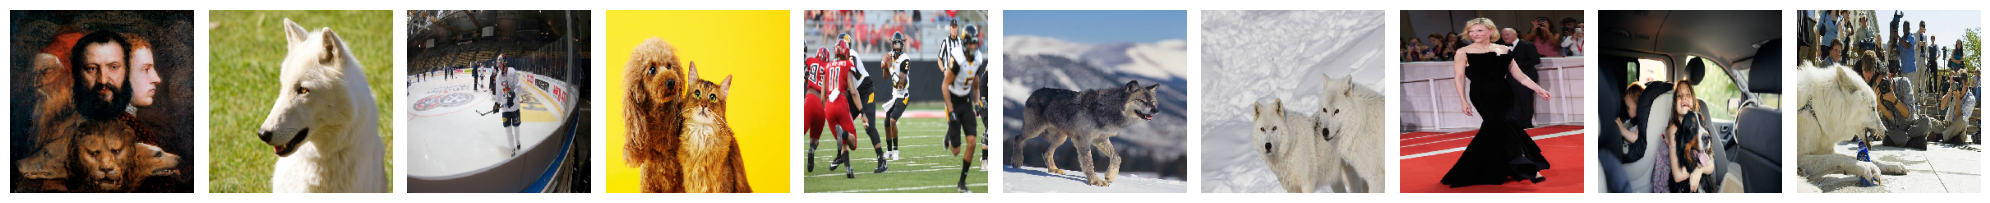

[[0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]


In [46]:
plotImages(imgs)
print(labels)

<h1>ResNet50</h1>

<h2>Training Model: ResNet50</h2>

In [ ]:
# ResNet50 Model
resnet50_model = ResNet50(weights=None, input_shape=(224, 224, 3), classes=len(train_batches.class_indices))

In [ ]:
resnet50_model.summary()

In [2]:
resnet50_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy',metrics=['accuracy'])
start_time = time.time()

NameError: name 'resnet50_model' is not defined

In [3]:
history1 = resnet50_model.fit(x=train_batches, validation_data = valid_batches, epochs =50, verbose = 2)
training_time = time.time() - start_time

NameError: name 'resnet_model' is not defined

<h2>Model Accuracy: ResNet50 </h2>

In [ ]:
plt.subplot(2,1,1)
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')

<h2>Training Loss: ResNet50</h2>

In [ ]:
plt.subplot(2,1,2)
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')

In [ ]:
test_imgs, test_labels = next(test_batches)
plotImages(test_imgs)
print(test_labels)

In [ ]:
test_batches.classes

In [ ]:
predictions = resnet50_model.predict(x=test_batches, verbose=0)

In [ ]:
np.round(predictions)

In [ ]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis = -1))

In [ ]:
def plot_confusion_matrix(cm,classes,
                         normalize = False, title = 'Confusion Matrix',
                         cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks,classes)
    
    if normalize:
        cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    thresh = cm.max()/2.
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,i, cm[i,j],
                horizontalalignment='center',
                color='white' if cm[i,j] > thresh else 'black')
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [ ]:
test_batches.class_indices

In [ ]:
cm_plot_labels = ['class1','class2', 'class3', 'class4']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [ ]:
loss,acc = resnet50_model.evaluate(test_imgs, test_labels, batch_size=32)

<h1>DenseNet121</h1>

<h2>Training Model: DenseNet121</h2>

In [ ]:
# ResNet50 Model
densenet121_model = DenseNet121(weights=None, input_shape=(224,224,3), classes=len(train_batches.class_indices)),

In [ ]:
densenet121_model.summary()

In [ ]:
densenet121_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy',metrics=['accuracy'])
start_time = time.time()

In [ ]:
history2 = densenet121_model.fit(x=train_batches, validation_data = valid_batches, epochs =50, verbose = 2)
training_time = time.time() - start_time

<h2>Model Accuracy: DenseNet121</h2>

In [ ]:
plt.subplot(2,1,1)
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')

<h2>Training Loss: DenseNet121</h2>

In [ ]:
plt.subplot(2,1,2)
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')

In [4]:
test_imgs, test_labels = next(test_batches)
plotImages(test_imgs)
print(test_labels)

NameError: name 'test_batches' is not defined

In [ ]:
test_batches.classes

In [ ]:
predictions = densenet121_model.predict(x=test_batches, verbose=0)

In [ ]:
np.round(predictions)

In [ ]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis = -1))

In [ ]:
def plot_confusion_matrix(cm,classes,
                         normalize = False, title = 'Confusion Matrix',
                         cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks,classes)
    
    if normalize:
        cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    thresh = cm.max()/2.
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,i, cm[i,j],
                horizontalalignment='center',
                color='white' if cm[i,j] > thresh else 'black')
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [ ]:
test_batches.class_indices

In [ ]:
cm_plot_labels = ['class1','class2', 'class3', 'class4']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [ ]:
loss,acc = densenet121_model.evaluate(test_imgs, test_labels, batch_size=32)

<h1>MobileNetV3</h1>

<h2>Training Model: MobileNetV3</h2>

In [ ]:
# ResNet50 Model
mobilenetv3_model = DenseNet121(weights=None, input_shape=(224,224,3), classes=len(train_batches.class_indices)),

In [ ]:
mobilenetv3_model.summary()

In [ ]:
mobilenetv3_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy',metrics=['accuracy'])
start_time = time.time()

In [ ]:
history3 = mobilenetv3_model.fit(x=train_batches, validation_data = valid_batches, epochs =50, verbose = 2)
training_time = time.time() - start_time

<h2>Model Accuracy: MobileNetV3</h2>

In [ ]:
plt.subplot(2,1,1)
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')

<h2>Training Loss: MobileNetV3</h2>

In [ ]:
plt.subplot(2,1,2)
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')

In [4]:
test_imgs, test_labels = next(test_batches)
plotImages(test_imgs)
print(test_labels)

NameError: name 'test_batches' is not defined

In [ ]:
test_batches.classes

In [ ]:
predictions = mobilenetv3_model.predict(x=test_batches, verbose=0)

In [ ]:
np.round(predictions)

In [ ]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis = -1))

In [ ]:
def plot_confusion_matrix(cm,classes,
                         normalize = False, title = 'Confusion Matrix',
                         cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks,classes)
    
    if normalize:
        cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    thresh = cm.max()/2.
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,i, cm[i,j],
                horizontalalignment='center',
                color='white' if cm[i,j] > thresh else 'black')
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [ ]:
test_batches.class_indices

In [ ]:
cm_plot_labels = ['class1','class2', 'class3', 'class4']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [ ]:
loss,acc = mobilenetv3_model.evaluate(test_imgs, test_labels, batch_size=32)